In [1]:
!pip install --upgrade  torchvision facenet-pytorch

INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 62.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 5.1 MB/s eta 0:00:000:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 6.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 27.

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image, ImageFile
import pandas as pd
import numpy as np
import os
import time

# To handle truncated images gracefully
ImageFile.LOAD_TRUNCATED_IMAGES = True

# --- Important Prerequisite ---
# This library is used for high-quality, on-the-fly face detection and alignment.
from facenet_pytorch import MTCNN

In [ ]:
import kagglehub
import shutil
# Download latest version
path = kagglehub.dataset_download("pdombrza/cacd-filtered-dataset")

shutil.copytree("/root/.cache/kagglehub/datasets/pdombrza/cacd-filtered-dataset", "/content/cacd-filtered-dataset")
#shutil.copytree("/kaggle/input/cacd-filtered-dataset", "/content/cacd-filtered-dataset")


'/content/cacd-filtered-dataset'

In [3]:
import os
import shutil
import pandas as pd

# Paths
csv_path = "/kaggle/input/cacd-filtered-dataset/CACD_features_sex.csv"
images_root = "/kaggle/input/cacd-filtered-dataset/cacd_split/cacd_split"
output_root = "/kaggle/working/cacd_filtered_top200"
output_csv_path = "/kaggle/working/CACD_features_top200.csv"
# Create output directory
os.makedirs(output_root, exist_ok=True)

# Load CSV
df = pd.read_csv(csv_path)

# Extract person folder name from image filename (e.g., "AaronAshmore" from "25_Aaron_Ashmore_0005.jpg")
df["person"] = df["name"].apply(lambda x: "_".join(x.split("_")[1:-1]).replace("_", ""))

# Step 1: Compute age variation per person
age_variation = df.groupby("person")["age"].agg(lambda x: x.max() - x.min())

# Step 2: Select top 1000 persons with largest age variation
top_persons = age_variation.sort_values(ascending=False).head(200).index

# Step 3: Filter dataframe
filtered_df = df[df["person"].isin(top_persons)].copy()

# Step 4: Copy images into new folder structure
for _, row in filtered_df.iterrows():
    person = row["person"]
    img_name = row["name"]  # e.g., "25_Aaron_Ashmore_0005.jpg"

    src = os.path.join(images_root, person, img_name)
    dst_dir = os.path.join(output_root, person)
    dst = os.path.join(dst_dir, img_name)

    os.makedirs(dst_dir, exist_ok=True)

    if os.path.exists(src):
        shutil.copy(src, dst)

# Step 5: Save new CSV
filtered_df.to_csv(output_csv_path, index=False)

print(f"✅ Done! Filtered dataset saved at: {output_root}")
print(f"CSV saved at: {output_csv_path}")


✅ Done! Filtered dataset saved at: /kaggle/working/cacd_filtered_top200
CSV saved at: /kaggle/working/CACD_features_top200.csv


In [ ]:
# shutil.copytree('/content/cacd_filtered_top200', '/content/drive/MyDrive/Cyshield Task/AIFR/cacd_filtered_top200')
# shutil.copy('/content/CACD_features_top200.csv', '/content/drive/MyDrive/Cyshield Task/AIFR/CACD_features_top200.csv')

'/content/drive/MyDrive/Cyshield Task/AIFR/CACD_features_top200.csv'

In [ ]:
#shutil.move("/kaggle/working/cacd_filtered_top1000/CACD_features_top1000.csv", "/kaggle/working/CACD_features_top1000.csv")

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# --- Configuration ---
CSV_PATH = '/kaggle/working/CACD_features_top200.csv'
IMAGE_DIR = '/kaggle/working/cacd_filtered_top200'

# --- Main Script ---

# 1. LOAD AND PREPARE DATA
print("--- 1. Loading and Preparing Data ---")
try:
    metadata_df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"ERROR: Metadata CSV not found at {CSV_PATH}")
    exit()

print(f"Loaded metadata with {len(metadata_df)} rows.")
print("\nMetadata Head (contains filename in 'name' column):")
print(metadata_df.head())

# Scan the image directory to get all existing image paths and their parent folder (identity name)
print("\nScanning image directory...")
all_image_paths = []
all_identity_names = []
# Using tqdm for a progress bar, which is helpful for large directories
for identity_name in tqdm(os.listdir(IMAGE_DIR)):
    identity_path = os.path.join(IMAGE_DIR, identity_name)
    if os.path.isdir(identity_path):
        for img_file in os.listdir(identity_path):
            if img_file.lower().endswith('.jpg'):
                all_image_paths.append(os.path.join(identity_path, img_file))
                all_identity_names.append(identity_name)

# Create a DataFrame from the actual files on disk
files_df = pd.DataFrame({
    'image_path': all_image_paths,
    'identity_name': all_identity_names
})
print(f"Found {len(files_df)} images on disk.")

# --- THE FIX IS HERE ---
# Create a 'filename' column by extracting the base name from the full path.
# This will be our merge key.
files_df['filename'] = files_df['image_path'].apply(os.path.basename)

print("\nfiles_df Head (with the new 'filename' key):")
print(files_df.head())

# Now, merge using the correct keys: 'filename' from our disk scan and 'name' from the CSV.
manifest_df = pd.merge(files_df, metadata_df, left_on='filename', right_on='name', how='inner')

--- 1. Loading and Preparing Data ---
Loaded metadata with 15700 rows.

Metadata Head (contains filename in 'name' column):
   Unnamed: 0  age  identity  year  rank  lfw  birth  \
0         319   53         5  2004     5    0   1951   
1         320   53         5  2004     5    0   1951   
2         321   53         5  2004     5    0   1951   
3         322   53         5  2004     5    0   1951   
4         323   53         5  2004     5    0   1951   

                          name gender          person  
0  53_Anjelica_Huston_0001.jpg      F  AnjelicaHuston  
1  53_Anjelica_Huston_0002.jpg      F  AnjelicaHuston  
2  53_Anjelica_Huston_0003.jpg      F  AnjelicaHuston  
3  53_Anjelica_Huston_0004.jpg      F  AnjelicaHuston  
4  53_Anjelica_Huston_0007.jpg      F  AnjelicaHuston  

Scanning image directory...


  0%|          | 0/200 [00:00<?, ?it/s]

Found 15700 images on disk.

files_df Head (with the new 'filename' key):
                                          image_path identity_name  \
0  /kaggle/working/cacd_filtered_top200/WillArnet...    WillArnett   
1  /kaggle/working/cacd_filtered_top200/WillArnet...    WillArnett   
2  /kaggle/working/cacd_filtered_top200/WillArnet...    WillArnett   
3  /kaggle/working/cacd_filtered_top200/WillArnet...    WillArnett   
4  /kaggle/working/cacd_filtered_top200/WillArnet...    WillArnett   

                  filename  
0  35_Will_Arnett_0010.jpg  
1  39_Will_Arnett_0012.jpg  
2  40_Will_Arnett_0013.jpg  
3  42_Will_Arnett_0011.jpg  
4  41_Will_Arnett_0009.jpg  


In [5]:
print(f"\nSuccessfully merged file paths with metadata. Resulting manifest has {len(manifest_df)} entries.")


Successfully merged file paths with metadata. Resulting manifest has 15700 entries.


In [6]:
manifest_df = manifest_df[['image_path', 'age']]

In [7]:
manifest_df

,image_path,age
0,/kaggle/working/cacd_filtered_top200/WillArnet...,35
1,/kaggle/working/cacd_filtered_top200/WillArnet...,39
2,/kaggle/working/cacd_filtered_top200/WillArnet...,40
3,/kaggle/working/cacd_filtered_top200/WillArnet...,42
4,/kaggle/working/cacd_filtered_top200/WillArnet...,41
...,...,...
15695,/kaggle/working/cacd_filtered_top200/AbbieCorn...,23
15696,/kaggle/working/cacd_filtered_top200/AbbieCorn...,27
15697,/kaggle/working/cacd_filtered_top200/AbbieCorn...,25
15698,/kaggle/working/cacd_filtered_top200/AbbieCorn...,25


In [8]:
# saving manifest csv
manifest_df.to_csv('/kaggle/working/manifest_df.csv', index=False)

In [9]:
# Import standard libraries
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Import torch and torchvision
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Import scikit-learn for data splitting
from sklearn.model_selection import train_test_split

# For progress bars
from tqdm.notebook import tqdm

In [10]:
# --- Configuration for Pre-processing ---
# This assumes your data is in /content/ as described in the prompt
CSV_PATH = '/kaggle/working/manifest_df.csv'
ORIGINAL_IMAGES_DIR = '/kaggle/working/cacd_filtered_top200/' # The root directory of original images
ALIGNED_IMAGES_DIR = '/kaggle/working/cacd_aligned/' # Directory to save processed images

# --- 1. Setup Device and MTCNN Model ---
# Automatically select GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

# Initialize MTCNN for face detection and alignment
# image_size: The size of the output cropped face
# margin: Adds padding around the detected face
mtcnn = MTCNN(image_size=224, margin=20, device=device, post_process=True)

# --- 2. Load DataFrame and Prepare Directories ---
df = pd.read_csv(CSV_PATH)

# Create the output directory if it doesn't exist
os.makedirs(ALIGNED_IMAGES_DIR, exist_ok=True)
print(f"Aligned images will be saved to: {ALIGNED_IMAGES_DIR}")

# --- 3. Process and Save Aligned Faces ---
failed_detections = []
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Images"):
    image_path = row['image_path']

    # It's good practice to construct the full path if the CSV contains relative paths
    # Based on your prompt, the path is already full. If it wasn't, you'd do:
    # full_path = os.path.join(ORIGINAL_IMAGES_DIR, image_path)
    full_path = image_path

    # Define the output path for the aligned image
    # We use os.path.basename to get the final filename (e.g., '38_Adam_Sandler_0002.jpg')
    output_path = os.path.join(ALIGNED_IMAGES_DIR, os.path.basename(full_path))

    # Skip if the aligned image already exists
    if os.path.exists(output_path):
        continue

    try:
        # Open the image
        img = Image.open(full_path).convert('RGB')

        # Detect face and save the aligned version
        # The `save` method of the MTCNN object handles the detection and saving
        mtcnn(img, save_path=output_path)

    except Exception as e:
        # This catches errors like file not found, corrupt images, or MTCNN failures
        failed_detections.append(full_path)
        print(f"\nFailed to process {full_path}. Error: {e}")

print(f"\nPre-processing complete.")
print(f"Total images failed: {len(failed_detections)}")
if failed_detections:
    print("Failed paths:", failed_detections)


Running on device: cuda:0
Aligned images will be saved to: /kaggle/working/cacd_aligned/


Processing Images:   0%|          | 0/15700 [00:00<?, ?it/s]


Pre-processing complete.
Total images failed: 0


In [11]:
# --- Configuration for Training ---
class Config:
    CSV_PATH = '/kaggle/working/manifest_df.csv'
    ALIGNED_IMAGES_DIR = '/kaggle/working/cacd_aligned/' # Use the aligned images!

    # Model and training parameters
    MODEL_NAME = 'densenet169' # Options: 'resnet50', 'densenet121', 'efficientnet_b0'
    PRETRAINED = True
    FINE_TUNE = True # If False, freezes the base model layers

    # Hyperparameters
    BATCH_SIZE = 32
    EPOCHS = 50
    LEARNING_RATE = 1e-4

    # Data splitting
    TEST_SPLIT_SIZE = 0.1
    VALIDATION_SPLIT_SIZE = 0.1

# Instantiate config
config = Config()

# Setup device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running training on device: {device}')

Running training on device: cuda:0


Data Split:
Training set size: 12560
Validation set size: 1570
Test set size: 1570


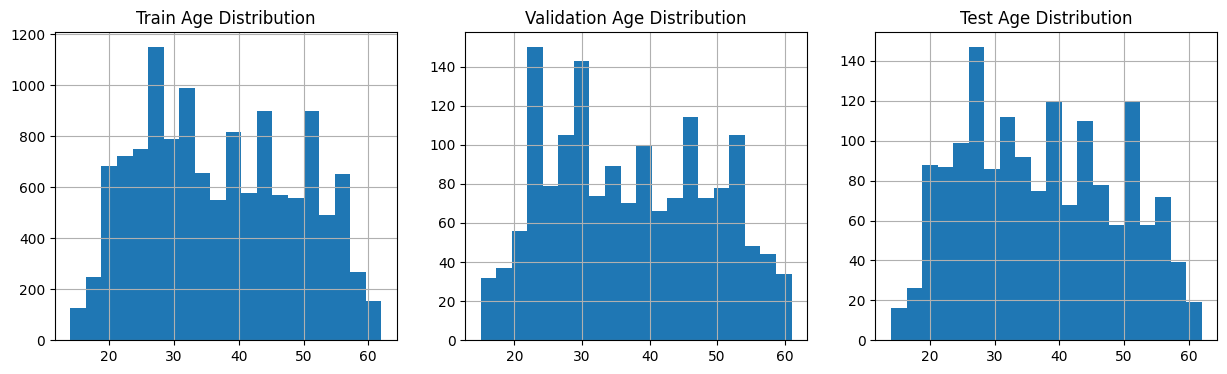

In [12]:
# --- Load the master dataframe ---
df = pd.read_csv(config.CSV_PATH)

# --- Create a new column with only the filename for easier lookup ---
df['filename'] = df['image_path'].apply(os.path.basename)

# --- Stratified Splitting ---
# We can't stratify on a continuous variable directly.
# So, we create bins (age groups) to stratify on, ensuring age distribution is maintained.
age_bins = pd.cut(df['age'], bins=np.arange(0, 101, 10), right=False)

# 1. Split off the test set
train_val_df, test_df = train_test_split(
    df,
    test_size=config.TEST_SPLIT_SIZE,
    stratify=age_bins,
    random_state=42
)

# 2. Split the remaining data into training and validation sets
# We need to re-calculate the bins for the remaining data
train_val_age_bins = pd.cut(train_val_df['age'], bins=np.arange(0, 101, 10), right=False)

# Adjust validation size relative to the remaining data
val_size_adjusted = config.VALIDATION_SPLIT_SIZE / (1 - config.TEST_SPLIT_SIZE)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_size_adjusted,
    stratify=train_val_age_bins,
    random_state=42
)

print(f"Data Split:")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Check age distribution in each split to confirm stratification
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
train_df['age'].hist(bins=20)
plt.title('Train Age Distribution')
plt.subplot(1, 3, 2)
val_df['age'].hist(bins=20)
plt.title('Validation Age Distribution')
plt.subplot(1, 3, 3)
test_df['age'].hist(bins=20)
plt.title('Test Age Distribution')
plt.show()


In [13]:
# --- Define Image Transformations ---
# We use standard ImageNet normalization values
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Custom PyTorch Dataset ---
class FaceAgeDataset(Dataset):

    def __init__(self, df, img_dir, transform=None):
          self.img_dir = img_dir
          self.transform = transform

          # ✅ Keep only rows where image exists
          valid_rows = []
          for i, row in df.iterrows():
              img_name = row['filename']
              img_path = os.path.join(self.img_dir, img_name)
              if os.path.exists(img_path):
                  valid_rows.append(row)
              else:
                  print(f"⚠️ Skipping missing image: {img_path}")

          # Rebuild dataframe with only valid rows
          self.df = pd.DataFrame(valid_rows).reset_index(drop=True)


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['filename']
        img_path = os.path.join(self.img_dir, img_name)

        # Check if the aligned image exists, otherwise we have a problem
        if not os.path.exists(img_path):
            # This case should be rare if pre-processing was successful
            # Handle it by returning None or a placeholder
            print(f"Warning: Aligned image not found at {img_path}")
            # To avoid crashing the DataLoader, we should return a placeholder
            # and handle it in the training loop, but for now we will raise an error
            raise FileNotFoundError(f"Aligned image not found at {img_path}")

        image = Image.open(img_path).convert('RGB')
        age = torch.tensor(row['age'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, age

# --- Create Datasets and DataLoaders ---
train_dataset = FaceAgeDataset(train_df, config.ALIGNED_IMAGES_DIR, data_transforms['train'])
val_dataset = FaceAgeDataset(val_df, config.ALIGNED_IMAGES_DIR, data_transforms['val'])
test_dataset = FaceAgeDataset(test_df, config.ALIGNED_IMAGES_DIR, data_transforms['val']) # No augmentation for test

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=0)

print("\nDataLoaders created successfully.")

⚠️ Skipping missing image: /kaggle/working/cacd_aligned/26_Ashley_Olsen_0007.jpg
⚠️ Skipping missing image: /kaggle/working/cacd_aligned/27_Ben_Foster_0003.jpg
⚠️ Skipping missing image: /kaggle/working/cacd_aligned/45_Ally_Sheedy_0005.jpg
⚠️ Skipping missing image: /kaggle/working/cacd_aligned/25_AnnaLynne_McCord_0007.jpg
⚠️ Skipping missing image: /kaggle/working/cacd_aligned/23_Aly_Michalka_0017.jpg
⚠️ Skipping missing image: /kaggle/working/cacd_aligned/59_Barbara_Niven_0002.jpg
⚠️ Skipping missing image: /kaggle/working/cacd_aligned/55_Arsenio_Hall_0009.jpg
⚠️ Skipping missing image: /kaggle/working/cacd_aligned/23_Aly_Michalka_0008.jpg
⚠️ Skipping missing image: /kaggle/working/cacd_aligned/45_Amy_Sedaris_0014.jpg
⚠️ Skipping missing image: /kaggle/working/cacd_aligned/46_Bai_Ling_0004.jpg

DataLoaders created successfully.


In [14]:
def build_model(model_name, pretrained=True, fine_tune=True):
    """
    Builds a pre-trained model for regression.

    Args:
        model_name (str): 'resnet50', 'densenet121', etc.
        pretrained (bool): Whether to use pre-trained weights.
        fine_tune (bool): If True, all layers are trainable. If False,
                          only the final classifier layer is trainable.
    """
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
    elif model_name == 'densenet169':
        model = models.densenet169(pretrained=pretrained)
    else:
        raise ValueError(f"Model {model_name} not supported.")

    # Set requires_grad based on fine_tune flag
    if not fine_tune:
        for param in model.parameters():
            param.requires_grad = False

    # Replace the final layer for regression (1 output)
    if 'resnet' in model_name:
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 1)
    elif 'densenet' in model_name:
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 1)

    return model

# --- Instantiate the model ---
model = build_model(
    model_name=config.MODEL_NAME,
    pretrained=config.PRETRAINED,
    fine_tune=config.FINE_TUNE
)
model = model.to(device)

print(f"Model '{config.MODEL_NAME}' loaded successfully.")
print(f"Fine-tuning set to: {config.FINE_TUNE}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:00<00:00, 140MB/s] 


Model 'densenet169' loaded successfully.
Fine-tuning set to: True


In [20]:
#!pip install --upgrade --force-reinstall torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124


In [15]:
criterion = nn.L1Loss()
optimizer = optim.Adam(params = model.parameters())

In [16]:
# --- Define Loss Function and Optimizer ---
# L1Loss corresponds to Mean Absolute Error (MAE)


# --- Training and Evaluation Functions ---
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        # Squeeze outputs to match labels shape: [B, 1] -> [B]
        loss = criterion(outputs.squeeze(), labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    return running_loss / len(loader.dataset)


def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()

            # Convert to numpy
            preds = outputs.detach().cpu().numpy()
            labels_np = labels.detach().cpu().numpy()

            # ✅ Ensure both are lists
            if preds.ndim == 0:
                preds = [preds.item()]
            else:
                preds = preds.tolist()

            if labels_np.ndim == 0:
                labels_np = [labels_np.item()]
            else:
                labels_np = labels_np.tolist()

            all_preds.extend(preds)
            all_labels.extend(labels_np)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    mae = np.mean(np.abs(all_preds - all_labels))
    mse = np.mean((all_preds - all_labels) ** 2)

    return mae, mse

In [ ]:
# --- Main Training Loop ---
best_val_mae = float('inf')
history = {'train_loss': [], 'val_mae': [], 'val_mse': []}

for epoch in range(config.EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{config.EPOCHS} ---")

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_mae, val_mse = evaluate(model, val_loader, device)

    history['train_loss'].append(train_loss)
    history['val_mae'].append(val_mae)
    history['val_mse'].append(val_mse)

    print(f"Epoch {epoch+1} Results:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Validation MAE: {val_mae:.4f}")
    print(f"  Validation MSE: {val_mse:.4f}")

    # Save the best model based on validation MAE
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), 'best_age_model.pth')
        print(f"  -> New best model saved with MAE: {best_val_mae:.4f}")

print("\nTraining finished.")


--- Epoch 1/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 Results:
  Train Loss: 9.8352
  Validation MAE: 7.8950
  Validation MSE: 102.2666
  -> New best model saved with MAE: 7.8950

--- Epoch 2/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 Results:
  Train Loss: 7.0999
  Validation MAE: 7.2327
  Validation MSE: 90.8880
  -> New best model saved with MAE: 7.2327

--- Epoch 3/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 Results:
  Train Loss: 6.6969
  Validation MAE: 7.9040
  Validation MSE: 102.5882

--- Epoch 4/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 Results:
  Train Loss: 6.3963
  Validation MAE: 6.2793
  Validation MSE: 68.5086
  -> New best model saved with MAE: 6.2793

--- Epoch 5/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 Results:
  Train Loss: 6.1902
  Validation MAE: 6.7520
  Validation MSE: 74.6899

--- Epoch 6/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6 Results:
  Train Loss: 6.0392
  Validation MAE: 5.9990
  Validation MSE: 62.9319
  -> New best model saved with MAE: 5.9990

--- Epoch 7/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 Results:
  Train Loss: 5.8171
  Validation MAE: 5.7818
  Validation MSE: 59.6913
  -> New best model saved with MAE: 5.7818

--- Epoch 8/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8 Results:
  Train Loss: 5.6707
  Validation MAE: 6.2252
  Validation MSE: 68.0606

--- Epoch 9/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9 Results:
  Train Loss: 5.5383
  Validation MAE: 5.8630
  Validation MSE: 60.7436

--- Epoch 10/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10 Results:
  Train Loss: 5.3326
  Validation MAE: 5.5844
  Validation MSE: 59.7670
  -> New best model saved with MAE: 5.5844

--- Epoch 11/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11 Results:
  Train Loss: 5.2895
  Validation MAE: 5.5376
  Validation MSE: 57.9938
  -> New best model saved with MAE: 5.5376

--- Epoch 12/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12 Results:
  Train Loss: 5.1559
  Validation MAE: 5.6252
  Validation MSE: 61.0688

--- Epoch 13/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13 Results:
  Train Loss: 5.0212
  Validation MAE: 5.2998
  Validation MSE: 53.3791
  -> New best model saved with MAE: 5.2998

--- Epoch 14/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14 Results:
  Train Loss: 4.9176
  Validation MAE: 5.4925
  Validation MSE: 55.8899

--- Epoch 15/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15 Results:
  Train Loss: 4.7724
  Validation MAE: 5.4790
  Validation MSE: 56.1827

--- Epoch 16/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16 Results:
  Train Loss: 4.6563
  Validation MAE: 5.4380
  Validation MSE: 56.0243

--- Epoch 17/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17 Results:
  Train Loss: 4.5337
  Validation MAE: 5.1397
  Validation MSE: 52.9376
  -> New best model saved with MAE: 5.1397

--- Epoch 18/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18 Results:
  Train Loss: 4.4481
  Validation MAE: 5.1161
  Validation MSE: 51.2578
  -> New best model saved with MAE: 5.1161

--- Epoch 19/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19 Results:
  Train Loss: 4.3860
  Validation MAE: 5.1568
  Validation MSE: 53.0442

--- Epoch 20/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20 Results:
  Train Loss: 4.2186
  Validation MAE: 5.1548
  Validation MSE: 51.8666

--- Epoch 21/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21 Results:
  Train Loss: 4.1019
  Validation MAE: 5.1691
  Validation MSE: 50.9254

--- Epoch 22/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22 Results:
  Train Loss: 4.0079
  Validation MAE: 5.1794
  Validation MSE: 50.1635

--- Epoch 23/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 23 Results:
  Train Loss: 3.9092
  Validation MAE: 5.1605
  Validation MSE: 51.4277

--- Epoch 24/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 24 Results:
  Train Loss: 3.7993
  Validation MAE: 4.9668
  Validation MSE: 48.9645
  -> New best model saved with MAE: 4.9668

--- Epoch 25/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 25 Results:
  Train Loss: 3.6785
  Validation MAE: 5.1259
  Validation MSE: 49.5546

--- Epoch 26/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26 Results:
  Train Loss: 3.6052
  Validation MAE: 4.8945
  Validation MSE: 48.2670
  -> New best model saved with MAE: 4.8945

--- Epoch 27/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 27 Results:
  Train Loss: 3.5087
  Validation MAE: 4.8877
  Validation MSE: 49.0353
  -> New best model saved with MAE: 4.8877

--- Epoch 28/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 28 Results:
  Train Loss: 3.3825
  Validation MAE: 4.9948
  Validation MSE: 49.8742

--- Epoch 29/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 29 Results:
  Train Loss: 3.3442
  Validation MAE: 5.3135
  Validation MSE: 56.2736

--- Epoch 30/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 30 Results:
  Train Loss: 3.2534
  Validation MAE: 4.8054
  Validation MSE: 48.1924
  -> New best model saved with MAE: 4.8054

--- Epoch 31/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 31 Results:
  Train Loss: 3.1517
  Validation MAE: 4.9825
  Validation MSE: 49.5471

--- Epoch 32/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 32 Results:
  Train Loss: 3.0663
  Validation MAE: 4.8924
  Validation MSE: 47.9589

--- Epoch 33/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 33 Results:
  Train Loss: 3.0324
  Validation MAE: 5.0099
  Validation MSE: 51.2886

--- Epoch 34/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 34 Results:
  Train Loss: 2.9704
  Validation MAE: 5.0399
  Validation MSE: 52.7805

--- Epoch 35/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 35 Results:
  Train Loss: 2.8927
  Validation MAE: 5.4521
  Validation MSE: 59.4500

--- Epoch 36/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 36 Results:
  Train Loss: 2.8096
  Validation MAE: 5.1683
  Validation MSE: 52.1475

--- Epoch 37/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 37 Results:
  Train Loss: 2.7453
  Validation MAE: 5.3591
  Validation MSE: 58.2293

--- Epoch 38/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 38 Results:
  Train Loss: 2.6762
  Validation MAE: 5.1371
  Validation MSE: 53.0091

--- Epoch 39/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

In [ ]:
# --- Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
# Load the best model weights
model.load_state_dict(torch.load('best_age_model.pth'))
test_mae, test_mse = evaluate(model, test_loader, device)

print(f"Test Set Results:")
print(f"  Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"  Mean Squared Error (MSE): {test_mse:.4f}")


--- Evaluating on Test Set ---


Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Test Set Results:
  Mean Absolute Error (MAE): 4.6684
  Mean Squared Error (MSE): 42.5811


In [ ]:
# --- Main Training Loop ---
best_val_mae = float('inf')
history = {'train_loss': [], 'val_mae': [], 'val_mse': []}

for epoch in range(config.EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{config.EPOCHS} ---")

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_mae, val_mse = evaluate(model, val_loader, device)

    history['train_loss'].append(train_loss)
    history['val_mae'].append(val_mae)
    history['val_mse'].append(val_mse)

    print(f"Epoch {epoch+1} Results:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Validation MAE: {val_mae:.4f}")
    print(f"  Validation MSE: {val_mse:.4f}")

    # Save the best model based on validation MAE
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), 'best_age_model.pth')
        print(f"  -> New best model saved with MAE: {best_val_mae:.4f}")

print("\nTraining finished.")


--- Epoch 1/50 ---


Training:   0%|          | 0/393 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]